In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import time

In [10]:
torch.manual_seed(1)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [11]:
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=transform)

training_DataLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testing_DataLoader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [12]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.Dense1 = nn.Linear(28*28, 128)
        self.Dense2 = nn.Linear(128, 64)
        self.Dense3 = nn.Linear(64, 32)
        self.Dense4 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.Dense1(x))
        x = F.relu(self.Dense2(x))
        x = F.relu(self.Dense3(x))
        x = self.Dense4(x)
        return x

In [13]:
def train(model, optimizer, epochs, train_loader):
    model.train()
    loss_func = torch.nn.CrossEntropyLoss()
    train_loss = []
    train_acc = []
    collected_weights_layer1 = []
    collected_weights_whole = []
    gradient_norms = []
    
    start_time = time.time()

    for epoch in range(epochs):
        correct = 0
        total_samples = 0
        batch_loss = []
        batch_acc = []
        grad_norm_epoch = []

        # Loop over batches
        for i, batch in enumerate(train_loader):
            images, labels = batch[0].to(device), batch[1].to(device)
            
            # Forward pass
            output = model(images)
            loss = loss_func(output, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            # Compute gradient norm before optimizer step
            total_norm = 0
            for p in model.parameters():
                param_norm = p.grad.detach().data.norm(2)
                total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
            grad_norm_epoch.append(total_norm)

            optimizer.step()

            # Update metrics
            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            batch_loss.append(loss.item())
            batch_acc.append(correct / total_samples)

        # Record gradient norms for this epoch
        gradient_norms.append(np.mean(grad_norm_epoch))

        if (epoch + 1) % 3 == 0:
            # Collect weights every 3 epochs
            with torch.no_grad():
                layer1_weights = np.zeros(0)
                whole_weights = np.zeros(0)
                for name, param in model.named_parameters():
                    if 'weight' in name:
                        whole_weights = np.concatenate((whole_weights, param.detach().cpu().numpy().reshape(-1)))
                        if 'Dense1' in name:
                            layer1_weights = np.concatenate((layer1_weights, param.detach().cpu().numpy().reshape(-1)))
            collected_weights_layer1.append(layer1_weights)
            collected_weights_whole.append(whole_weights)

        # Calculate average loss and accuracy for the epoch
        train_loss.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))

        # Display progress update
        elapsed_time = time.time() - start_time
        progress = (epoch + 1) / epochs * 100
        print(f"Epoch {epoch + 1}/{epochs} | "
              f"Loss: {train_loss[-1]:.4f} | "
              f"Accuracy: {train_acc[-1] * 100:.2f}% | "
              f"Progress: {progress:.2f}% | "
              f"Elapsed time: {elapsed_time:.2f}s")

    return train_loss, train_acc, collected_weights_layer1, collected_weights_whole, gradient_norms


In [14]:
def apply_pca(weights):
    w = np.array(weights)
    print(w.shape)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(w)
    return pca_result

In [15]:
epochs = 24
layer_1_pca = []
whole_pca = []
train_acc_arr = []
train_loss_arr = []
gradient_norms_arr = []

# Run 8 training events and collect data
for i in range(8):
    print(f"Train Event {i + 1}")
    model = DNN().to(device)
    optimizer1 = optim.Adam(model.parameters(), lr=1e-4)
    train_loss, train_acc, layer1_weights, whole_weights, grad_norms = train(model, optimizer1, epochs, training_DataLoader)
    pca_out_layer1 = apply_pca(layer1_weights)
    pca_out_whole = apply_pca(whole_weights)
    layer_1_pca.append(pca_out_layer1)
    whole_pca.append(pca_out_whole)
    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    gradient_norms_arr.append(grad_norms)

Train Event 1
Epoch 1/24 | Loss: 0.7480 | Accuracy: 64.36% | Progress: 4.17% | Elapsed time: 8.85s
Epoch 2/24 | Loss: 0.2890 | Accuracy: 91.41% | Progress: 8.33% | Elapsed time: 17.73s
Epoch 3/24 | Loss: 0.2298 | Accuracy: 93.15% | Progress: 12.50% | Elapsed time: 26.58s
Epoch 4/24 | Loss: 0.1950 | Accuracy: 94.26% | Progress: 16.67% | Elapsed time: 35.48s
Epoch 5/24 | Loss: 0.1709 | Accuracy: 94.89% | Progress: 20.83% | Elapsed time: 44.42s
Epoch 6/24 | Loss: 0.1507 | Accuracy: 95.65% | Progress: 25.00% | Elapsed time: 53.34s
Epoch 7/24 | Loss: 0.1356 | Accuracy: 95.86% | Progress: 29.17% | Elapsed time: 62.26s
Epoch 8/24 | Loss: 0.1226 | Accuracy: 96.33% | Progress: 33.33% | Elapsed time: 71.21s
Epoch 9/24 | Loss: 0.1117 | Accuracy: 96.66% | Progress: 37.50% | Elapsed time: 80.06s
Epoch 10/24 | Loss: 0.1023 | Accuracy: 97.05% | Progress: 41.67% | Elapsed time: 88.88s
Epoch 11/24 | Loss: 0.0938 | Accuracy: 97.11% | Progress: 45.83% | Elapsed time: 97.70s
Epoch 12/24 | Loss: 0.0866 | A

In [16]:
def plot_weights(pca_layer, plot_name):
    fig = plt.figure(figsize=(10, 8))
    plt.xlabel('Weight PC1')
    plt.ylabel('Weight PC2')
    plt.title(plot_name)
    
    for i in range(len(pca_layer)):
        W_i = pca_layer[i]
        plt.scatter(W_i[:, 0], W_i[:, 1], label=f'Training Event {i + 1}')
    
    plt.legend()
    plt.show()

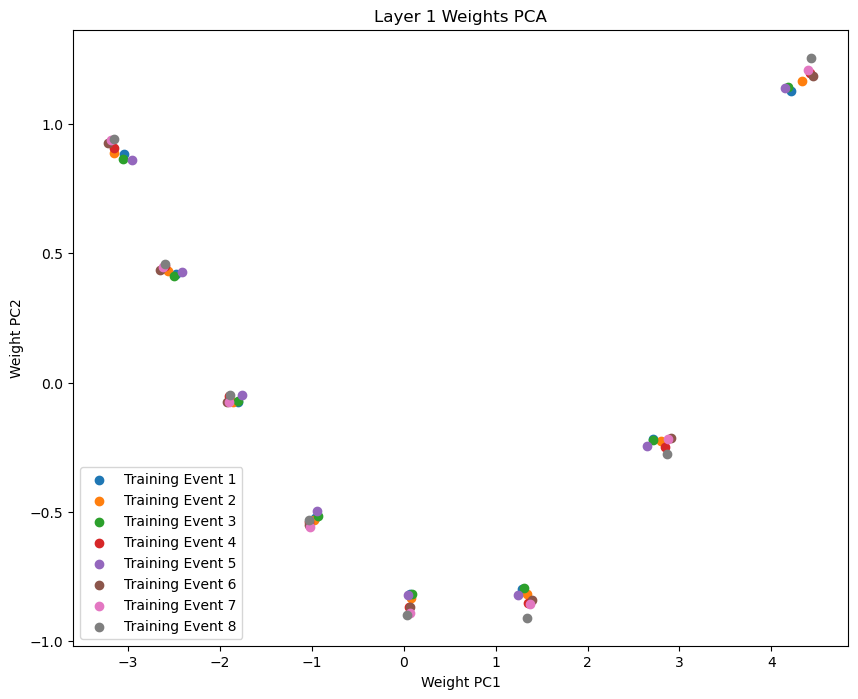

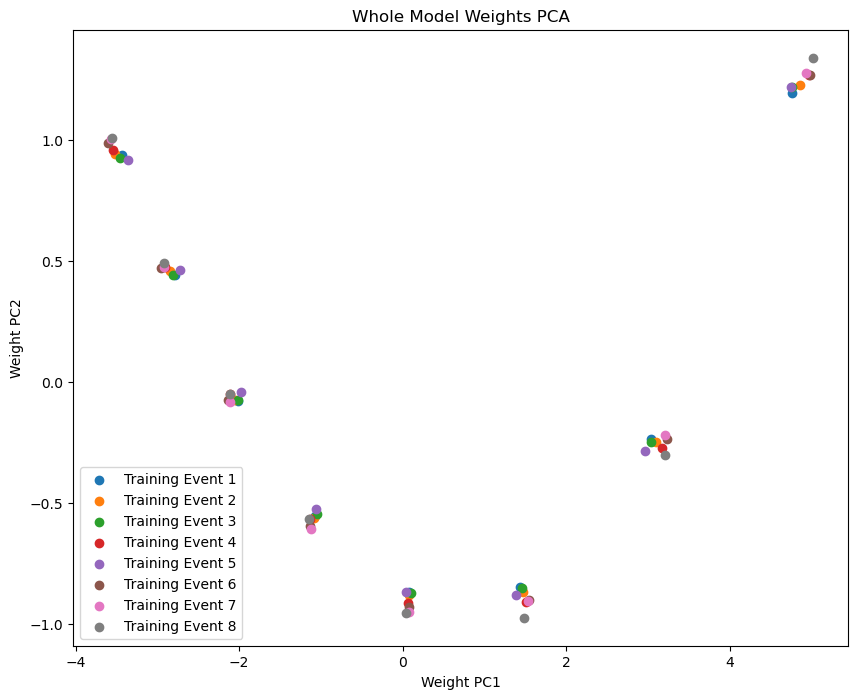

In [17]:
plot_weights(layer_1_pca, "Layer 1 Weights PCA")
plot_weights(whole_pca, "Whole Model Weights PCA")

In [18]:
def plot_gradient_norms(grad_norms, plot_name):
    plt.figure(figsize=(10, 6))
    for i, norms in enumerate(grad_norms):
        plt.plot(norms, label=f'Training Event {i + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient Norm')
    plt.title(plot_name)
    plt.legend()
    plt.show()

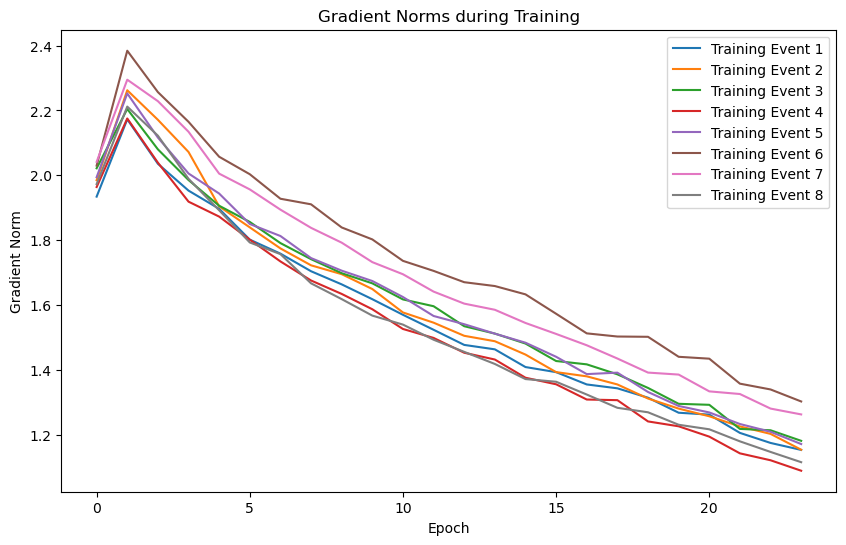

In [19]:
plot_gradient_norms(gradient_norms_arr, "Gradient Norms during Training")